In [2]:
!pip -q install sacrebleu
!pip -q install googletrans
!pip -q install tensorflow-addons --upgrade
# https://www.kaggle.com/wahyusetianto/machine-translation-en-jp-seq2seq-tf#Build-&-Train-Model
# git remote add origin https://gitlab.com/nourine.berrekia/medical-multiword-expressions-nmt-keras-and-tensorflow.git

     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.0MB 35.1MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 686kB 34.3MB/s 


In [5]:
import random, re, string, itertools, timeit, sacrebleu
import numpy as np
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#track training lpp iterations in terms of time, loss  and backprpagating the loss values 
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
# Tensorflow & Keras
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
#treat Embeding LAYER, dense layer and RNN LSTM layer
from tensorflow.keras.layers import Input, Dense, LSTM, LSTMCell
#Bidirectionnel RNN 
from tensorflow.keras.layers import Embedding, Bidirectional
#Model developped into the encoder class and decoder class
from tensorflow.keras.models import Model
#TF Tokenizer and preprocessing functions
from tensorflow.keras.preprocessing.text import Tokenizer
#TF packge paad sequence method
from tensorflow.keras.preprocessing.sequence import pad_sequences
#track the loss between the encoder and the decoder of the Model in training and cheeckpoints 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
#Adam Optimizer to opti
from tensorflow.keras.optimizers import Adam
plt.style.use('seaborn-pastel')



In [6]:
#Use spaCy's language models 
import pandas as pd
import numpy as np

In [7]:
"""Import the dataset from the Drive, in case training on Google Collab"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# df = pd.read_csv('../Train and Test Corpus/DATASET_2_10_revised.csv',sep='\t',encoding='utf8',names =["en","fr"], error_bad_lines=False)
df = pd.read_csv('/content/drive/MyDrive/NMT_04_2021/DATASET_2_10_revised.csv',sep='\t',encoding='utf8',names=['en','fr'], error_bad_lines=False)

df.describe()

en                         fr
count                                          76703                      76703
unique                                         65349                      68141
top     Polyarticular juvenile idiopathic arthritis.  Ελλάδα Roche Hellas A. E.
freq                                               7                          5

<h4> Model Evaluation</h4>
<br>
<h8>The first model train and test corpus of 10000</h8><br>
<h8>The second model train and test corpus of 35000</h8><br>
<h8>The Third model train and test corpus of 75000</h8><br>
<h4> I. Evaluation of the third model</h4>

In [10]:
"""
Selection and visualisation some features in the rows 35000
First attempt == baseline model

"""
from sklearn.utils import shuffle
df = shuffle(df)
pd.set_option('display.max_rows', 76500) # edit how jupyter will render our pandas dataframes
pd.options.mode.chained_assignment = None
min_df = df[:76400]
(len(min_df.index))
mini_df = min_df

mini_df.shape



(76400, 2)

In [11]:
import re
mispell_dict = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "i would",
    "i'd" : "i had",
    "i'll" : "i will",
    "i'm" : "i am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "i have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying",
    "til":"t il",

}
mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))

def preprocess(text) -> str:
    def replace(match):
        return mispell_dict[match.group(0)]
    
    text = mispell_re.sub(replace, text)
    return text
print(preprocess('fast lexperience nos ra questce'))


fast lexperience nos ra questce


In [12]:
# The last preprocessing function before evaluation
import string
exclude = set(string.punctuation)
CP = lambda x : x.translate(str.maketrans('', '', string.punctuation))
CP(preprocess('je suis /! la lexperience ra kent'))

'je suis  la lexperience ra kent'

In [13]:
# FR_train, FR_test
from sklearn.model_selection import train_test_split
X, y = mini_df['en'], mini_df['fr']
eng_train, eng_test, fr_train, fr_test = train_test_split(X, y, test_size = 0.1,random_state=42)
eng_train.shape, eng_test.shape

# THE model will be trained on (en fr) TRAIN DATA and Tested on TEST DATA


((68760,), (7640,))

In [14]:
#UNK To be deleted 
from tensorflow.keras.preprocessing.text import Tokenizer
eng_train = ['bos '+ x + ' eos' for x in eng_train + ['unk unk unk']]

fr_train = ['bos '+ x + ' eos' for x in fr_train + ['unk unk unk']]

eng_val = ['bos '+ x + ' eos' for x in eng_test]
# fr_val == fr_val
fr_val = ['bos '+ x + ' eos' for x in fr_test]



In [16]:
# English Tokenizer
en_tokenizer = Tokenizer(filters='')
en_tokenizer.fit_on_texts(eng_train)

# Japannese Tokenizer
fr_tokenizer = Tokenizer(filters='')
fr_tokenizer.fit_on_texts(fr_train)

In [17]:
print(f'English vocab size   :', len(en_tokenizer.word_index)-3)
print(f'french vocab size  :', len(fr_tokenizer.word_index)-3)

English vocab size   : 28853
french vocab size  : 35107


In [19]:
def Sequences(texts, tokenizer):
    res = []
    for text in texts:
        seq = []
        for w in text.split():
            try:
                seq.append(tokenizer.word_index[w])
            except:
                seq.append(tokenizer.word_index['unk'])
        res.append(seq)
    return res

In [20]:
# Transform Sentences to Sequences
data_en = en_tokenizer.texts_to_sequences(eng_train)
data_fr = fr_tokenizer.texts_to_sequences(fr_train)

val_en = Sequences(eng_val, en_tokenizer)
val_fr = Sequences(fr_val, fr_tokenizer)
print(f'English vocab size   :', len(val_en))
print(f'french vocab size  :', len(val_fr))

English vocab size   : 7640
french vocab size  : 7640


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


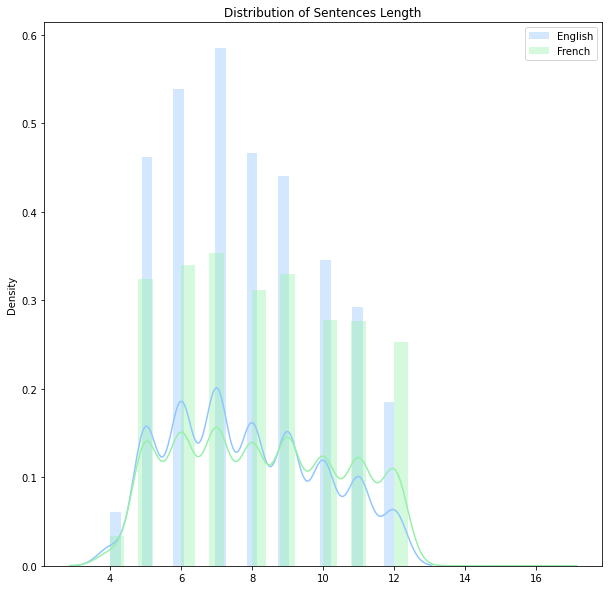

In [21]:
plt.figure(figsize = (10,10))
sns.distplot([len(x) for x in val_en], label='English')
sns.distplot([len(x) for x in val_fr], label='French')
plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

In [22]:
#check the features max length
#https://stackoverflow.com/questions/52181164/trying-to-understand-kerass-tokenizer-texts-to-sequences/52181452
max_en = max([len(x) for x in data_en] + [len(x) for x in val_en])
max_fr = max([len(x) for x in data_fr]+ [len(x) for x in val_fr])
print(f'Maximum length of English sequences is  {max_en}')
print(f'Maximum length of FRench sequences is {max_fr}')

Maximum length of English sequences is  14
Maximum length of FRench sequences is 18


In [23]:
# Padding Sequences
data_en = pad_sequences(data_en, padding='post', maxlen = max_en)
data_fr = pad_sequences(data_fr, padding='post', maxlen = max_fr)

val_en = pad_sequences(val_en, padding='post', maxlen = max_en)
val_fr = pad_sequences(val_fr, padding='post', maxlen = max_fr)

In [ ]:
"""
Build and train the model -   Baseline 20 -- final model to 50
"""
# Config
epochs = 10 
BATCH_SIZE = 128 
BUFFER_SIZE = len(data_fr)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
val_steps_per_epoch = len(val_fr) // BATCH_SIZE
embedding_dims = 256 
rnn_units = 1024 # Units needed in each layer 
dense_units = 1024 #dense units to acrivation function in the encoder 
Dtype = tf.float32

In [ ]:
#This function return the Max Length of the sequence to apply  tokensation and word embedding
def max_len(tensor):
    """
    Get max len in Sequences
    """
    return max( len(t) for t in tensor)

In [ ]:
# Max Len
Tx = max_len(data_en)
Ty = max_len(data_fr)

# Vocab
input_vocab_size = len(en_tokenizer.word_index) + 1   # English
output_vocab_size = len(fr_tokenizer.word_index) + 1  # French

# Changging to TF data embedding with tensorflow 
dataset = (tf.data.Dataset.from_tensor_slices((data_en, data_fr))
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
          )

val_dataset = (tf.data.Dataset.from_tensor_slices((val_en, val_fr))
               .batch(BATCH_SIZE)
              )

In [ ]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units ):
        super().__init__()
        #added and to be deleted
        self.rnn_units = rnn_units
        #encoder 
        self.encoder_embedding = Embedding(input_dim=input_vocab_size,
                                           output_dim=embedding_dims)
        #LSTM layer
        self.encoder_rnnlayer = LSTM(rnn_units,return_sequences=True,
                                     return_state=True,
                                     recurrent_initializer='glorot_uniform'#added 
                                     )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = Embedding(input_dim=output_vocab_size,
                                           output_dim=embedding_dims) 
        #activation : softmax retourne un score de 1 en entrainement et perte de valeur de 0.6 
        self.dense_layer = Dense(output_vocab_size) 
        # units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
        self.decoder_rnncell = LSTMCell(rnn_units)
        # self.decoder_rnncell = LSTMCell(rnn_units,activation='softma')
        
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = \
            self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[Tx])
        self.rnn_cell = self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell,
                                                sampler= self.sampler,
                                                output_layer = self.dense_layer
                                               )

    def build_attention_mechanism(self, units, memory, MSL):
        """
        MSL : Memory Sequence Length
        """
        #return tfa.seq2seq.LuongAttention(units, memory = memory, 
        #                                  memory_sequence_length = MSL)
        return tfa.seq2seq.BahdanauAttention(units, memory = memory, 
                                             memory_sequence_length = MSL)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size):
        return tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, 
                                            self.attention_mechanism,
                                            attention_layer_size=dense_units)
    
    def build_decoder_initial_state(self, batch_size, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state = encoder_state) 
        return decoder_initial_state

In [ ]:
# Build Model
encoderNetwork = EncoderNetwork(input_vocab_size, embedding_dims, rnn_units)
decoderNetwork = DecoderNetwork(output_vocab_size, embedding_dims, rnn_units)

# Optimizer
optimizer = tf.keras.optimizers.Adam()


In [ ]:

def loss_function(y_pred, y):
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = SparseCategoricalCrossentropy(from_logits=True,
                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #avoid output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask * loss
    loss = tf.reduce_mean(loss)
    return loss

@tf.function
def train_step(input_batch, output_batch, encoder_initial_cell_state):
    # initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state = encoder_initial_cell_state)

        # [last step activations,last memory_state] of 
        # encoder passed as input to decoder Network
         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore eos
        # compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore bos

        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        # Setting up decoder memory from encoder output 
        # and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)
        
        # BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[Ty-1])

        logits = outputs.rnn_output
        
        # Calculate loss
        loss = loss_function(logits, decoder_output)

    # Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    # grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

@tf.function
def evaluate(input_batch, output_batch, encoder_initial_cell_state):
    loss = 0
    encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
    a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                    initial_state =encoder_initial_cell_state)
    decoder_input = output_batch[:,:-1]
    decoder_output = output_batch[:,1:]
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)
    decoderNetwork.attention_mechanism.setup_memory(a)
    decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                       encoder_state=[a_tx, c_tx],
                                                                       Dtype=tf.float32)
    outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                           sequence_length=BATCH_SIZE*[Ty-1])
    logits = outputs.rnn_output
    loss = loss_function(logits, decoder_output)
    return loss



In [ ]:
# RNN LSTM hidden and memory state initializer
def initialize_initial_state():
    return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]



In [ ]:
# Translate
def Translate(input_raw):
    #Preprocess and revice the words 
    input_raw = CP(preprocess(input_raw))
    input_lines = ['bos '+ input_raw + '']#the input start from 'bos'
    
    input_sequences, unique = [], []
    for line in input_lines:
        temp = []
        for w in line.split(' '):
            try:
                temp.append(en_tokenizer.word_index[w])
            except: # Avoid Error
                unique.append(w)
                temp.append(en_tokenizer.word_index['out'])
        input_sequences.append(temp)
    
    #read the input and and its max length dropping the post padding
    input_sequences = pad_sequences(input_sequences, maxlen=Tx, padding='post')
    inp = tf.convert_to_tensor(input_sequences)
    inference_batch_size = input_sequences.shape[0]
    encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                                  tf.zeros((inference_batch_size, rnn_units))]
    encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
    a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                    initial_state = encoder_initial_cell_state)

    start_tokens = tf.fill([inference_batch_size], fr_tokenizer.word_index['bos'])

    end_token = fr_tokenizer.word_index['eos']

    greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

    decoder_input = tf.expand_dims([fr_tokenizer.word_index['bos']] * inference_batch_size,1)
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

    decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, 
                                                sampler = greedy_sampler,
                                                output_layer = decoderNetwork.dense_layer)
    decoderNetwork.attention_mechanism.setup_memory(a)

    decoder_initial_state = decoderNetwork.build_decoder_initial_state(
        inference_batch_size, encoder_state=[a_tx, c_tx], Dtype=tf.float32)

    maximum_iterations = tf.round(tf.reduce_max(Tx) * 2)

    decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 
    (first_finished, first_inputs,first_state) = decoder_instance.initialize(
        decoder_embedding_matrix, start_tokens = start_tokens,
        end_token = end_token, initial_state = decoder_initial_state)

    inputs = first_inputs
    state = first_state  
    predictions = np.empty((inference_batch_size,0), dtype = np.int32)                                                              
    for j in range(maximum_iterations):
        outputs, next_state, next_inputs, finished = decoder_instance.step(j, inputs,state)
        inputs = next_inputs
        state = next_state
        outputs = np.expand_dims(outputs.sample_id,axis = -1)
        predictions = np.append(predictions, outputs, axis = -1)
        
    res = ''
    for i in range(len(predictions)):
        line = predictions[i,:]
        seq = list(itertools.takewhile(lambda index: index !=2, line))
        res += " ".join([fr_tokenizer.index_word[w] for w in seq])
    res = res.split()
    
    # Return back Unique words
    for i in range(len(res)):
        if res[i] == 'unk' and unique != []:
            res[i] = unique.pop(0) 
    
    return ' '.join(res)

# Calculate BLEU
def BLEU(X, y):
    # Prediction
    pred = [Translate(w) for w in tqdm(X)]
    # Calculate BLEU 
    score = sacrebleu.corpus_bleu(pred, [y]).score / 100
    return score, pred


In [ ]:
# Custom Train Progress
class Progress:
    #Figure init objects
    def __init__(self):
        self.fig = plt.figure(figsize = (8,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.loss, self.val_loss, self.BLEU = [], [], []
        self.epoch_loss = 0
        
    #Track the val_loss
    def get_val_loss(self):
        return [x[1] for x in self.val_loss]
        
    # Plot the loss:trainingloss, val_loss:test_loss, and B
    def dynamic_plot(self):
        self.ax.cla()
        self.ax.plot(range(len(self.loss)), self.loss, label='loss')
        if len(self.val_loss) >= 1:
            x = [l[0] for l in self.val_loss]
            y = [l[1] for l in self.val_loss]
            self.ax.plot(x, y, color = 'r', label='val_loss')
            self.ax.plot(x, self.BLEU, color = 'purple', label='BLEU')
        self.ax.set_ylim(0,)
        self.ax.legend(loc = 1)
        display(self.fig)
    
    # Train step progress
    def train_progress(self, epoch, step, steps_per_epoch, start):
        self.dynamic_plot()
        print(f'Working on Epoch {epoch}')
        print('[' + ('=' * int((step + 1) / steps_per_epoch * 60)).ljust(61, ' ') 
              + f']  {step + 1}/{steps_per_epoch} - loss : {round(self.epoch_loss / step, 4)}')
        print(f'Time per Step {round(timeit.default_timer() - start, 2)} s')
        
    def summary(self):
        loss = np.array_split(np.array(self.loss), len(self.val_loss))
        loss = [np.mean(x) for x in loss]
        val_loss = [x[1] for x in self.val_loss]
        dff = pd.DataFrame({'Epochs' : range(1, len(val_loss) + 1), 'loss' : loss,
                           'val loss' : val_loss, 'BLEU' : self.BLEU})
        
        self.dynamic_plot()
        clear_output(wait = True)
        display(dff)

In [ ]:
# Initialize Train Progress
TP = Progress()
best_prediction = []

for i in range(1, epochs + 1):

    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0
    # Train Loss
    TP.epoch_loss = 0

    # Train
    for (batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        start = timeit.default_timer()
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
        TP.loss.append(batch_loss.numpy())
        TP.epoch_loss += batch_loss.numpy()
            
        if (batch+1) % 30 == 0:
            TP.train_progress(i, batch, steps_per_epoch, start)
            clear_output(wait = True)
    
    # Validitate
    encoderNetwork.trainable = False  # Freeze our model layer to make sure
    decoderNetwork.trainable = False  # it didn't learn anything from val_data
    
    # Valid loss
    val_loss = 0
    for (batch, (input_batch, output_batch)) in enumerate(val_dataset.take(val_steps_per_epoch)):
        batch_loss = evaluate(input_batch, output_batch, encoder_initial_cell_state)
        val_loss += batch_loss.numpy()
    val_loss /= val_steps_per_epoch
    
    TP.val_loss.append((i * steps_per_epoch - 1, val_loss))
    
    # Bleu Score
    bleu_score, pred = BLEU(eng_test,fr_test)
    # bleu_score = BLEU(eng_test,fr_test)
    TP.BLEU.append(bleu_score)
    
    encoderNetwork.trainable = True  # Unfreeze layer for next epoch
    decoderNetwork.trainable = True
    
    # Save best model
    if bleu_score == max(TP.BLEU) and val_loss == min(TP.get_val_loss()):
        best_prediction = pred
        encoderNetwork.save_weights('encoderNetwork')
        decoderNetwork.save_weights('decoderNetwork')

TP.summary()

In [ ]:
# Load best weights
encoderNetwork.load_weights('encoderNetwork')
decoderNetwork.load_weights('decoderNetwork')

#the bleu score mean on the length of epochs
sum(TP.BLEU)/len(TP.BLEU)

0.10725575101483883

In [ ]:
#the sum of best BLEU score OF 70000 DATASET LINES and 0.1 test size
sum(TP.BLEU)

0.3635478704591813

In [ ]:
sum(TP.loss)

3691.9346289634705

In [ ]:
TP.epoch_loss


165.60676059126854

In [ ]:
# from googletrans import Translator
# # Google Translate
# translator = Translator()

<h7>In a previous work and before traing this model, I make use of a simple keras model with a encoder LSTM and one decoder LSTM without attention mechanism. 
This model gives a precision of 63% over loss of 27% on the TEST dataset. to do this we use the Keras aamazing method model.evaluate()
The latter is only applied on the test data as further as we cannot use it on the tainnig process. </h7>
<h6>Let's cnheck the EPLs translations with the inference model in the second program</h6>